In [1]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

In [2]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

2024-11-18 10:25:44.031899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 10:25:44.031950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 10:25:44.033148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:25:44.039442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 10:25:44.735559: W tensorflow/compiler/tf2

tensorflow version: 2.15.0
Num GPUs Available:  1


2024-11-18 10:25:45.892987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 10:25:45.920000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 10:25:45.920180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

time: 50.7 ms (started: 2024-11-18 10:25:45 +00:00)


In [4]:
#parameter
n_steps_in = 90  # Number of days to look back
n_steps_out = 40  # Number of days to predict ahead
epochs = 50
batch_size = 64

time: 323 µs (started: 2024-11-18 10:25:45 +00:00)


In [5]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 59.6 ms (started: 2024-11-18 10:25:45 +00:00)


In [6]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(
                train_features, 
                train_targets,
                n_steps_in,
                n_steps_out
            )
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(
                val_features,
                val_targets,
                n_steps_in,
                n_steps_out
            )
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(
    values_list,
    n_steps_in,
    n_steps_out,
    train_split=0.8
)

Training shapes: X=(34865, 14, 20), y=(34865, 5)
Validation shapes: X=(8474, 14, 20), y=(8474, 5)
Number of features: 20
time: 84.9 ms (started: 2024-11-18 10:25:45 +00:00)


In [7]:
def create_lstm_model(n_steps_in, n_features, n_steps_out):
    """
    Create LSTM model for stock price prediction.
    
    Args:
        n_steps_in: Number of input time steps
        n_features: Number of features
        n_steps_out: Number of prediction days
        
    Returns:
        model: Compiled LSTM model
    """
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = [tf.keras.losses.MeanAbsoluteError(name='mse')]
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    model.compile(optimizer=optimizer, loss_weights=[1], loss=loss, metrics=metrics)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, 
                          n_features=train_X.shape[2], 
                          n_steps_out=n_steps_out
                         )

2024-11-18 10:25:46.108914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 10:25:46.109167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 10:25:46.109295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 14455 (56.46 KB)
Trainable params: 14455 (56.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 1.61 s (started: 2024-11-18 10:25:46 +00:00)


In [8]:
# Train model
history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    shuffle=False
)

Epoch 1/50


2024-11-18 10:25:50.201291: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa020009a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 10:25:50.201328: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-11-18 10:25:50.206977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-18 10:25:50.545665: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1731925550.629382    5970 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 - 9s - loss: 0.0406 - rmse: 0.0669 - val_loss: 0.0185 - val_rmse: 0.0300 - 9s/epoch - 17ms/step
Epoch 2/50
545/545 - 6s - loss: 0.0124 - rmse: 0.0194 - val_loss: 0.0129 - val_rmse: 0.0195 - 6s/epoch - 10ms/step
Epoch 3/50
545/545 - 6s - loss: 0.0098 - rmse: 0.0157 - val_loss: 0.0140 - val_rmse: 0.0192 - 6s/epoch - 11ms/step
Epoch 4/50
545/545 - 6s - loss: 0.0088 - rmse: 0.0144 - val_loss: 0.0155 - val_rmse: 0.0204 - 6s/epoch - 11ms/step
Epoch 5/50
545/545 - 6s - loss: 0.0082 - rmse: 0.0137 - val_loss: 0.0157 - val_rmse: 0.0209 - 6s/epoch - 10ms/step
Epoch 6/50
545/545 - 6s - loss: 0.0079 - rmse: 0.0132 - val_loss: 0.0167 - val_rmse: 0.0221 - 6s/epoch - 10ms/step
Epoch 7/50
545/545 - 6s - loss: 0.0076 - rmse: 0.0129 - val_loss: 0.0168 - val_rmse: 0.0223 - 6s/epoch - 10ms/step
Epoch 8/50
545/545 - 6s - loss: 0.0074 - rmse: 0.0126 - val_loss: 0.0165 - val_rmse: 0.0222 - 6s/epoch - 11ms/step
Epoch 9/50
545/545 - 6s - loss: 0.0072 - rmse: 0.0123 - val_loss: 0.0162 - val_rmse: 0.0221

In [9]:
# Make predictions
y_pred = model.predict(val_X)

# Evaluate for each time step
for i in range(n_steps_out):
    mae = np.mean(np.abs(val_y[:, i] - y_pred[:, i]))
    print(f"MAE for step {i+1}: {mae: .4f}")

265/265 [==============================] - 1s 3ms/step
MAE for step 1:  0.0082
MAE for step 2:  0.0102
MAE for step 3:  0.0121
MAE for step 4:  0.0109
MAE for step 5:  0.0148
time: 953 ms (started: 2024-11-18 10:30:33 +00:00)


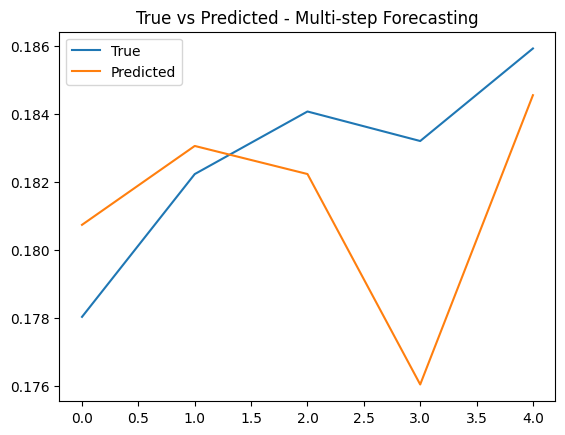

time: 123 ms (started: 2024-11-18 10:30:34 +00:00)


In [10]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

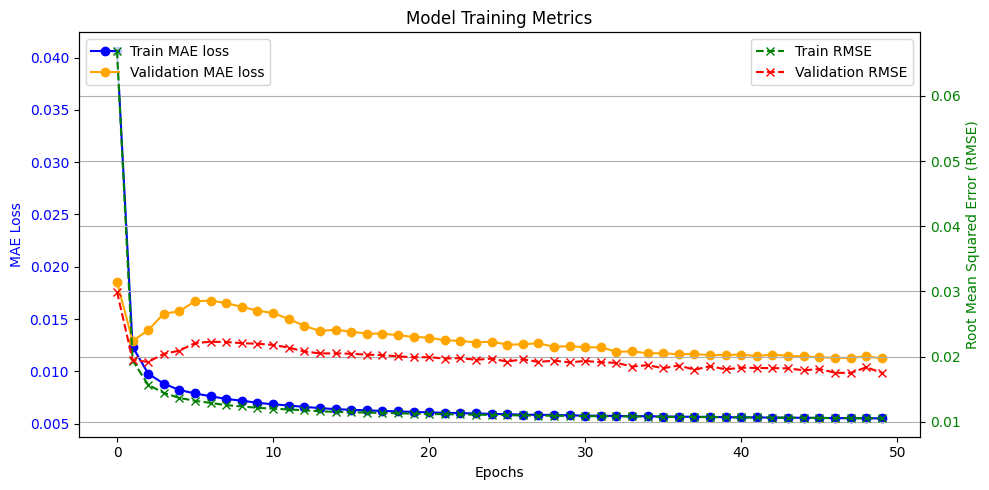

time: 223 ms (started: 2024-11-18 10:37:51 +00:00)


In [20]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MAE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MAE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# RMSE plot (shared x-axis, different y-axis)
ax2 = ax1.twinx()
ax2.plot(epoch_range, history.history["rmse"], label='Train RMSE', marker='x', color='green', linestyle='--')
ax2.plot(epoch_range, history.history["val_rmse"], label='Validation RMSE', marker='x', color='red', linestyle='--')
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Model Training Metrics')
plt.grid()
plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 38.1098
RMSE: 6.1733
MAE: 5.1655


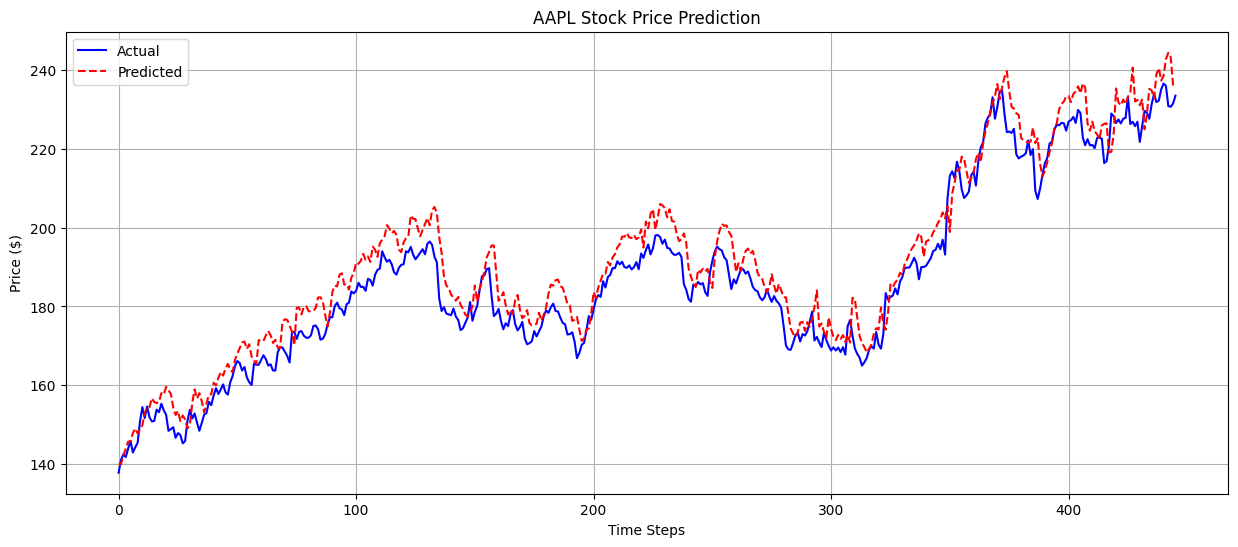


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 37.5197
RMSE: 6.1253
MAE: 5.0483


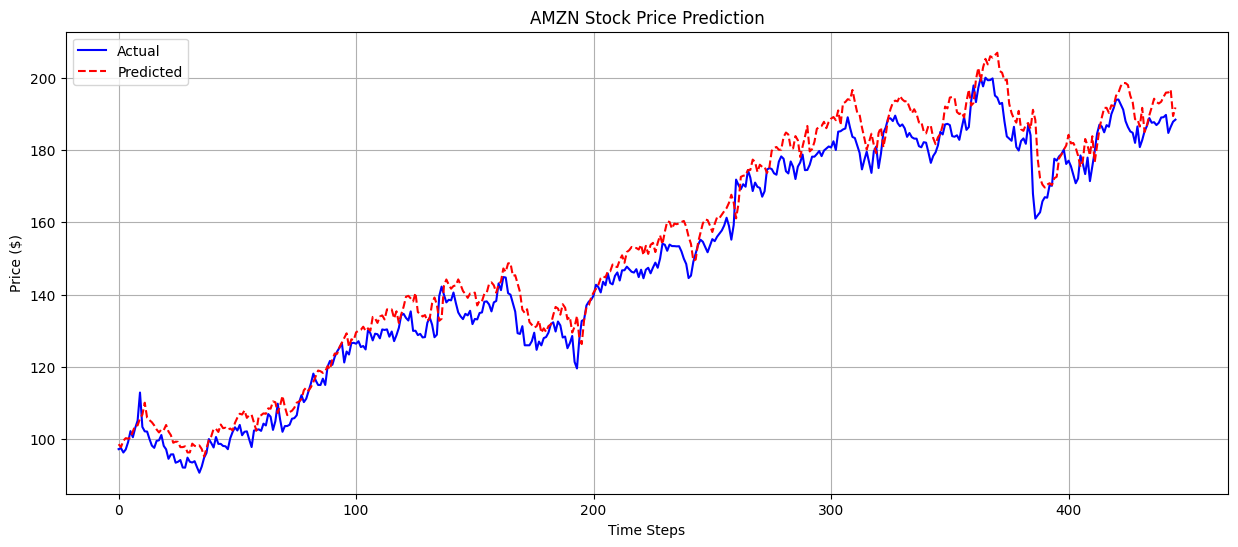


Analyzing GME...

Evaluation Metrics for GME:
MSE: 10.6655
RMSE: 3.2658
MAE: 2.4129


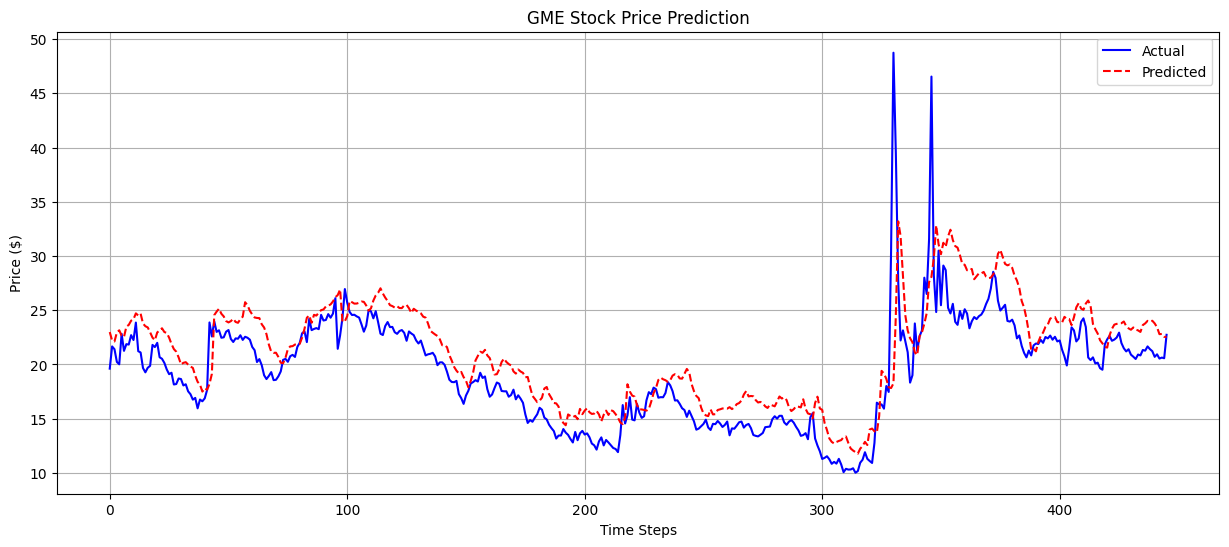


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 36.6671
RMSE: 6.0553
MAE: 5.0427


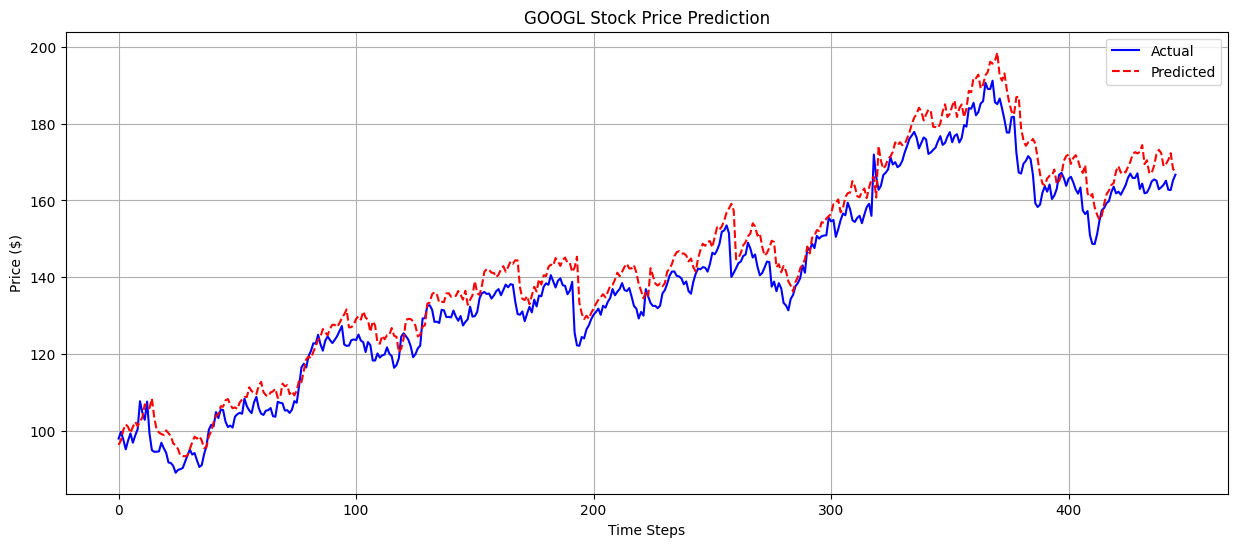


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 666.2692
RMSE: 25.8122
MAE: 19.3190


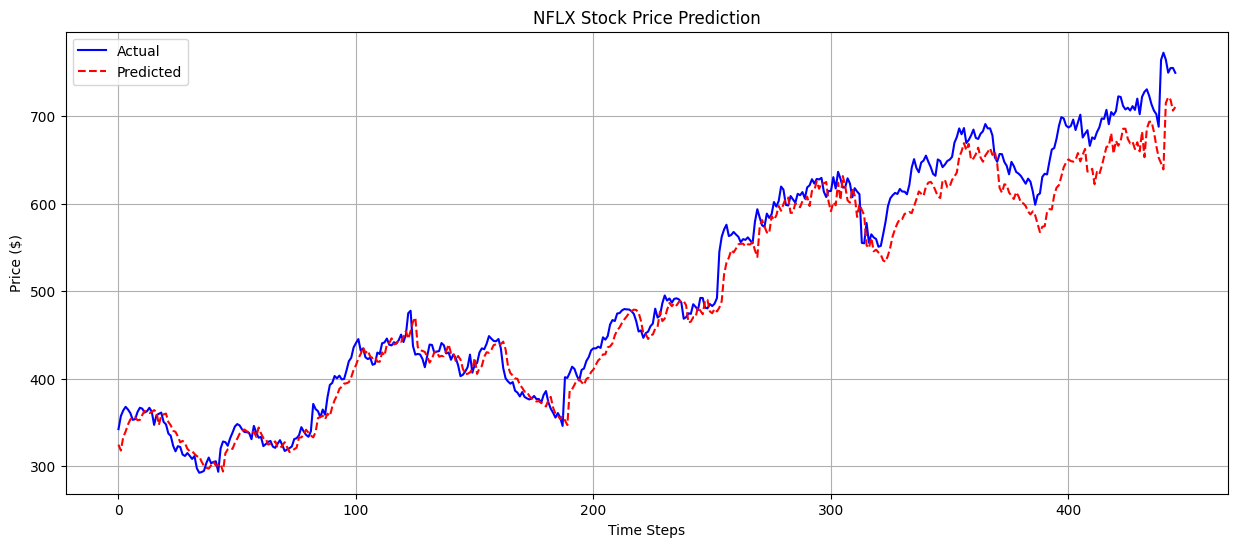


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 155.8543
RMSE: 12.4842
MAE: 9.3645


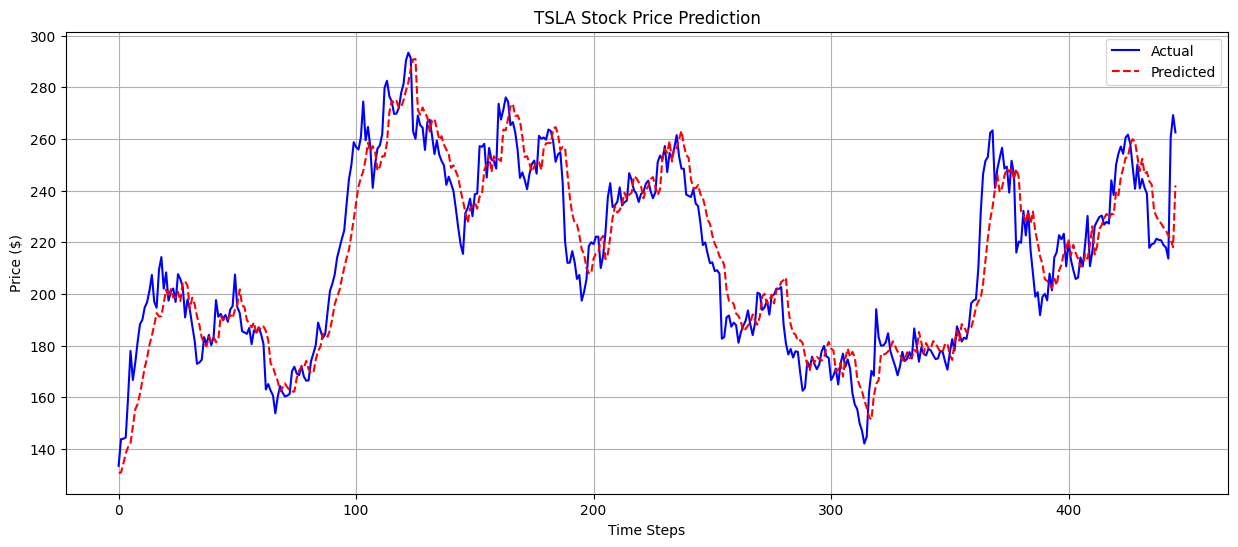


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 57.4482
RMSE: 7.5795
MAE: 5.9024


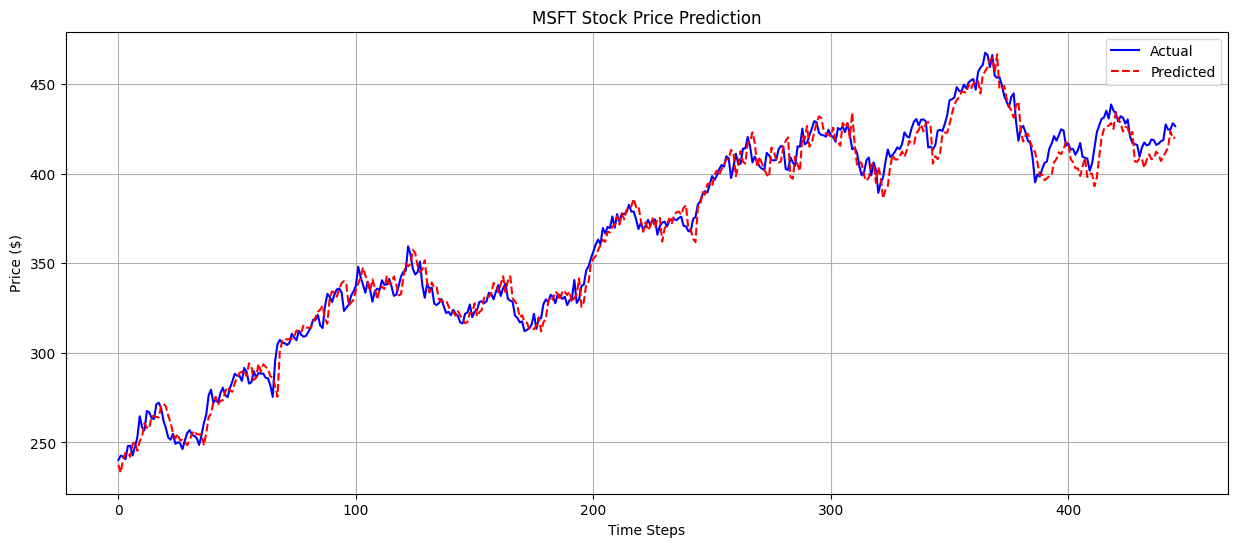


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 16.6200
RMSE: 4.0768
MAE: 2.8485


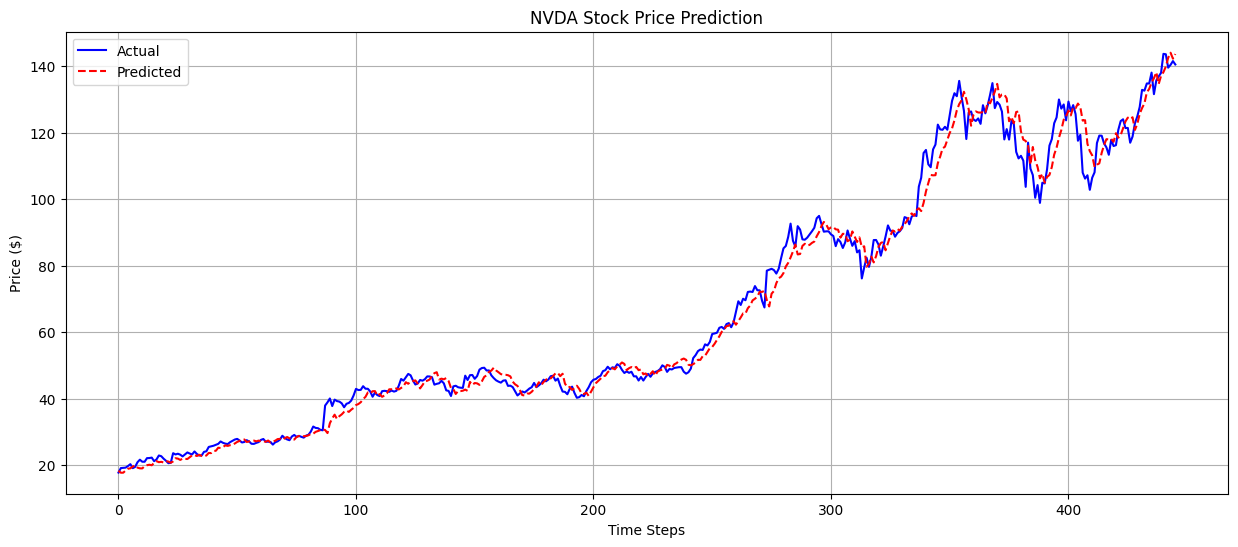


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 51.7624
RMSE: 7.1946
MAE: 5.6163


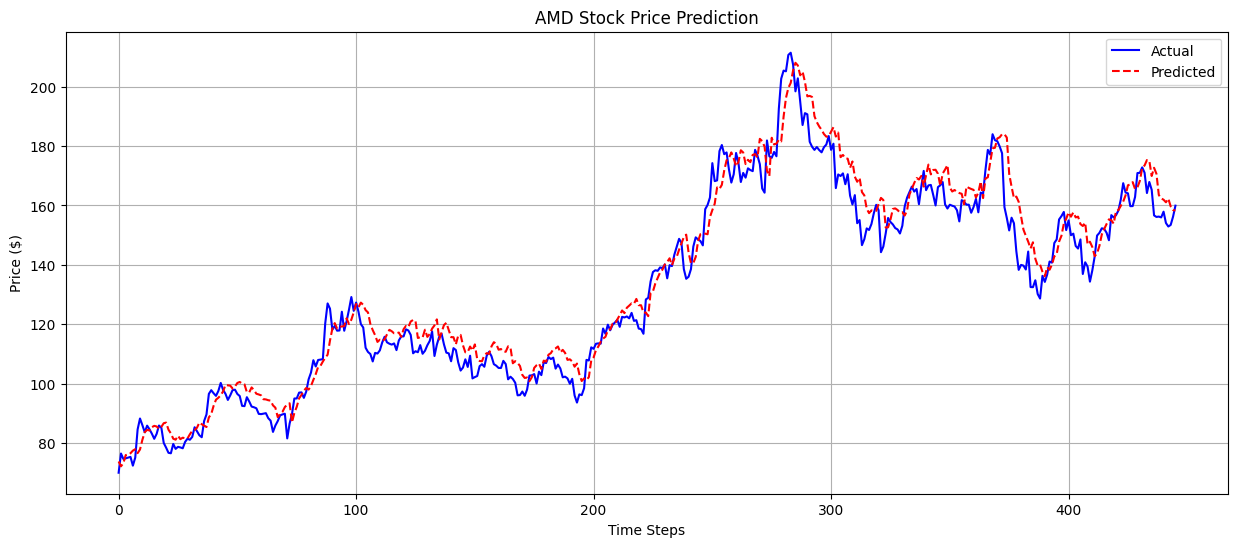


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 57.8592
RMSE: 7.6065
MAE: 5.6608


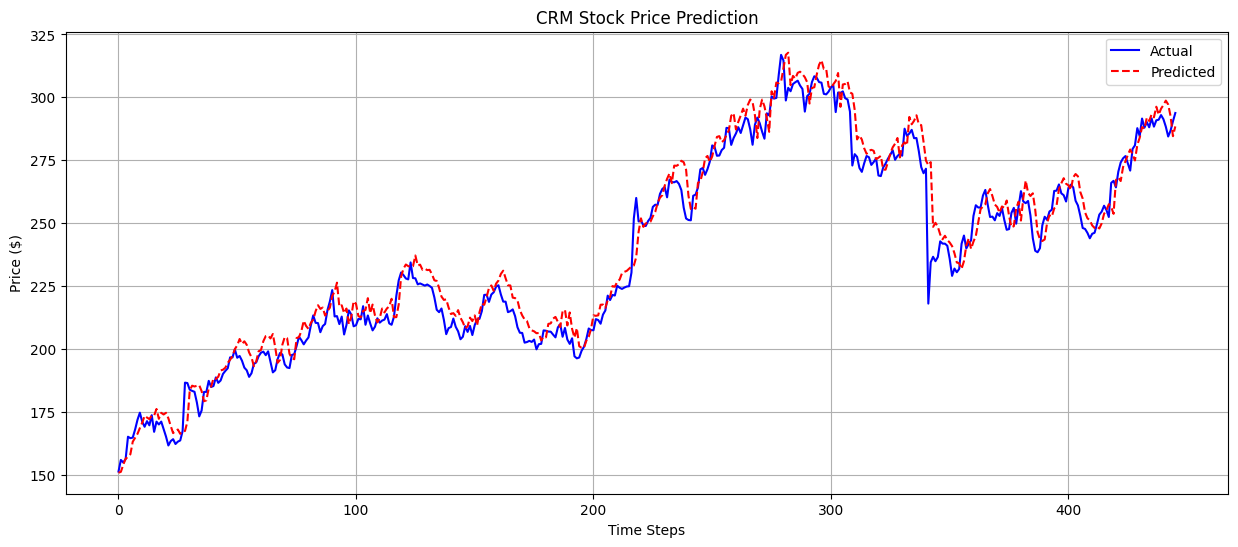


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 40.0908
RMSE: 6.3317
MAE: 5.4893


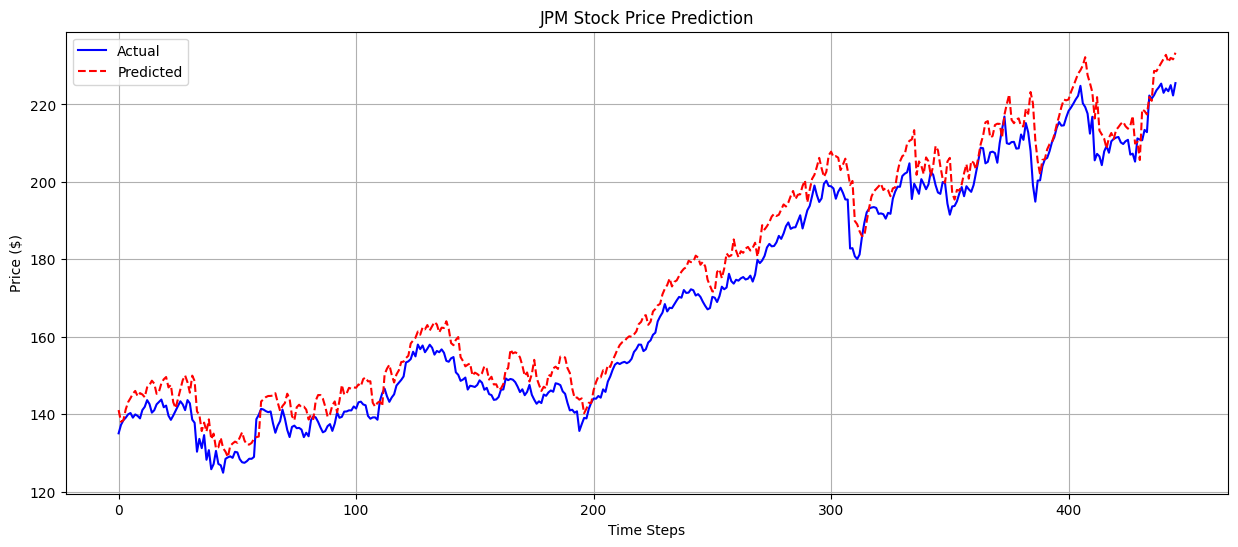


Analyzing V...

Evaluation Metrics for V:
MSE: 40.9493
RMSE: 6.3992
MAE: 5.3194


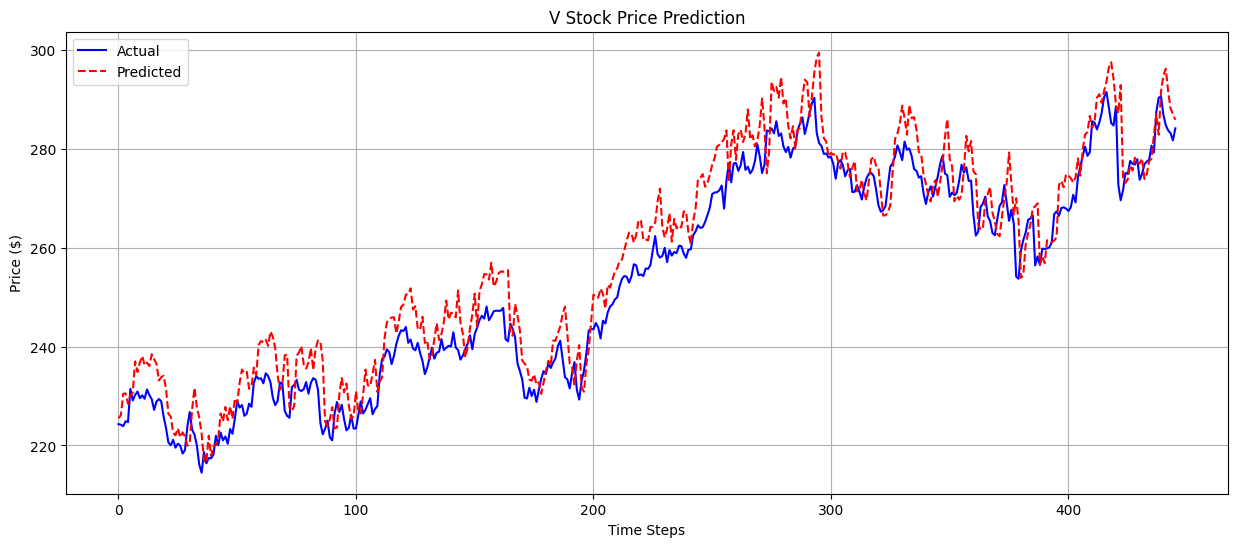


Analyzing MA...

Evaluation Metrics for MA:
MSE: 87.4423
RMSE: 9.3511
MAE: 7.4310


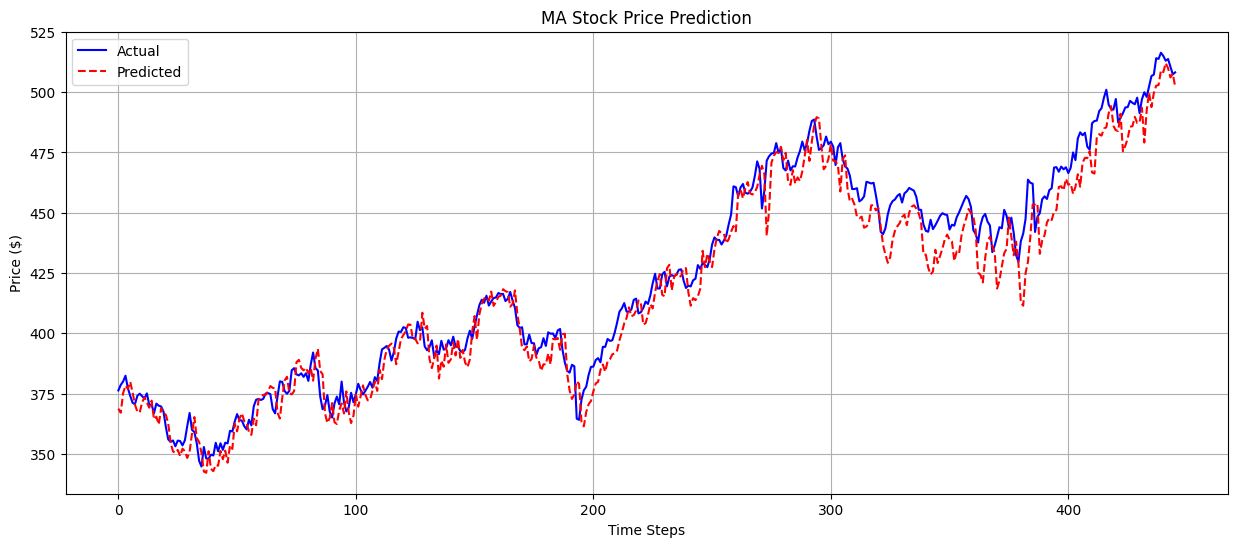


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 116.8473
RMSE: 10.8096
MAE: 6.5266


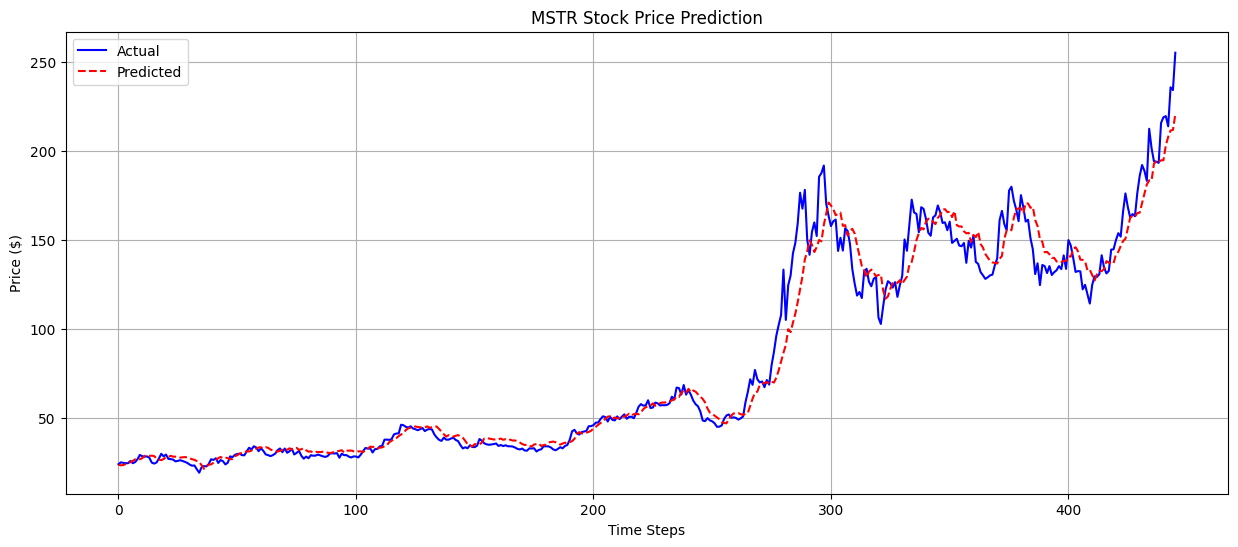


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 26.9987
RMSE: 5.1960
MAE: 4.6848


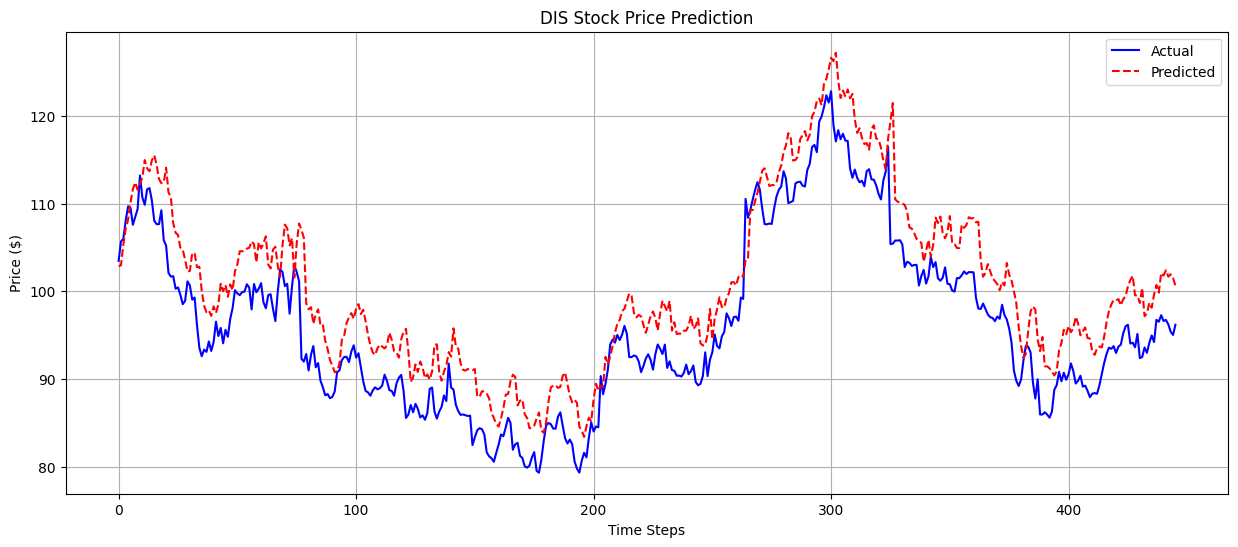


Analyzing BA...

Evaluation Metrics for BA:
MSE: 55.5249
RMSE: 7.4515
MAE: 5.8843


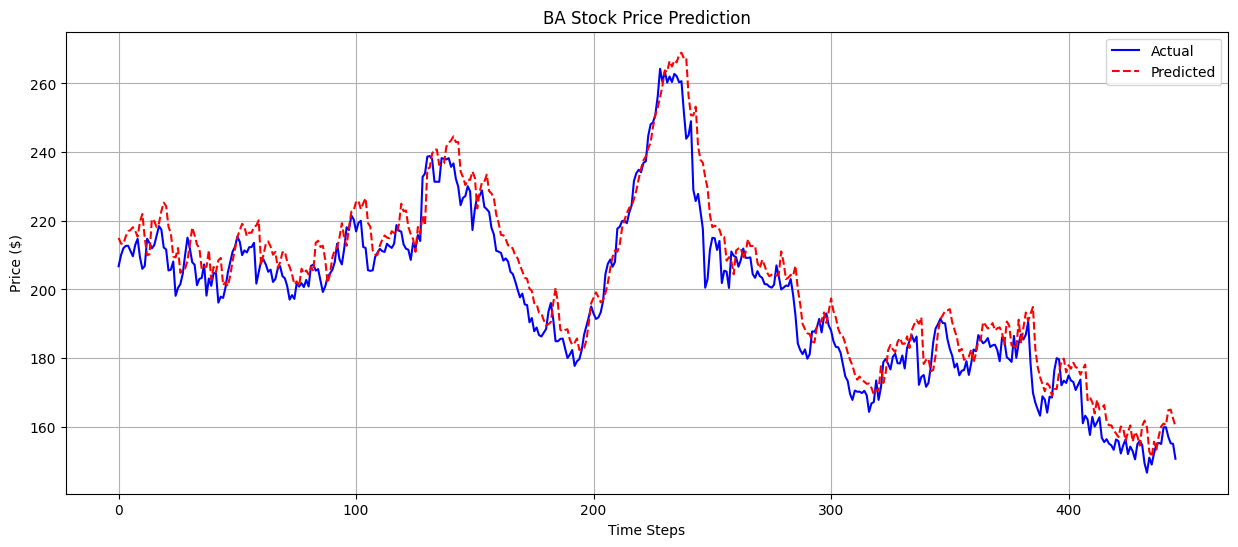


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 27.7447
RMSE: 5.2673
MAE: 4.7162


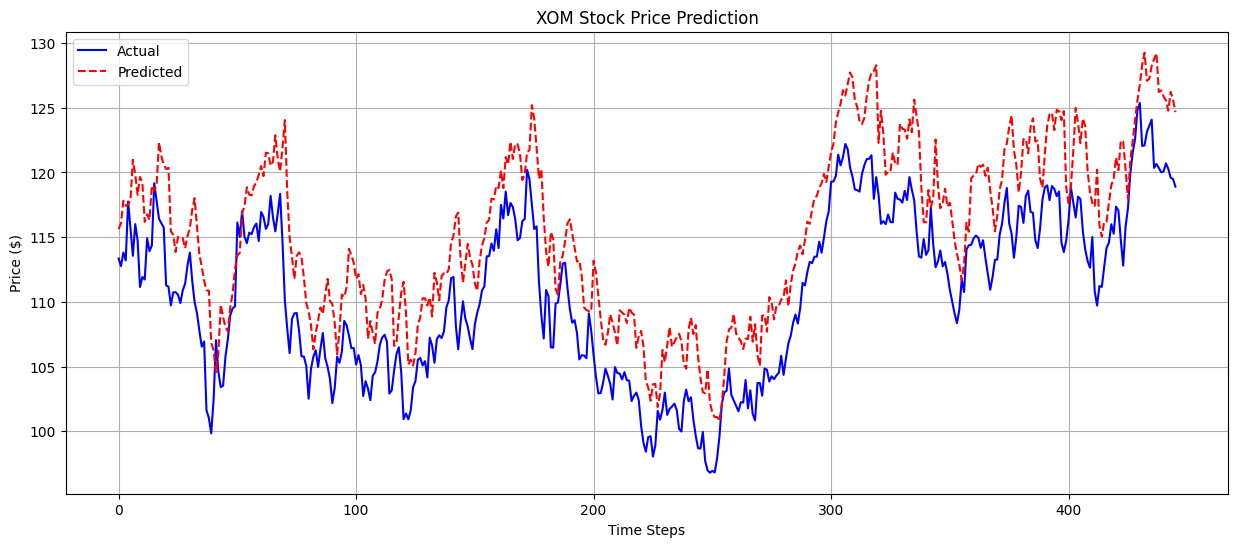


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 32.0232
RMSE: 5.6589
MAE: 4.8733


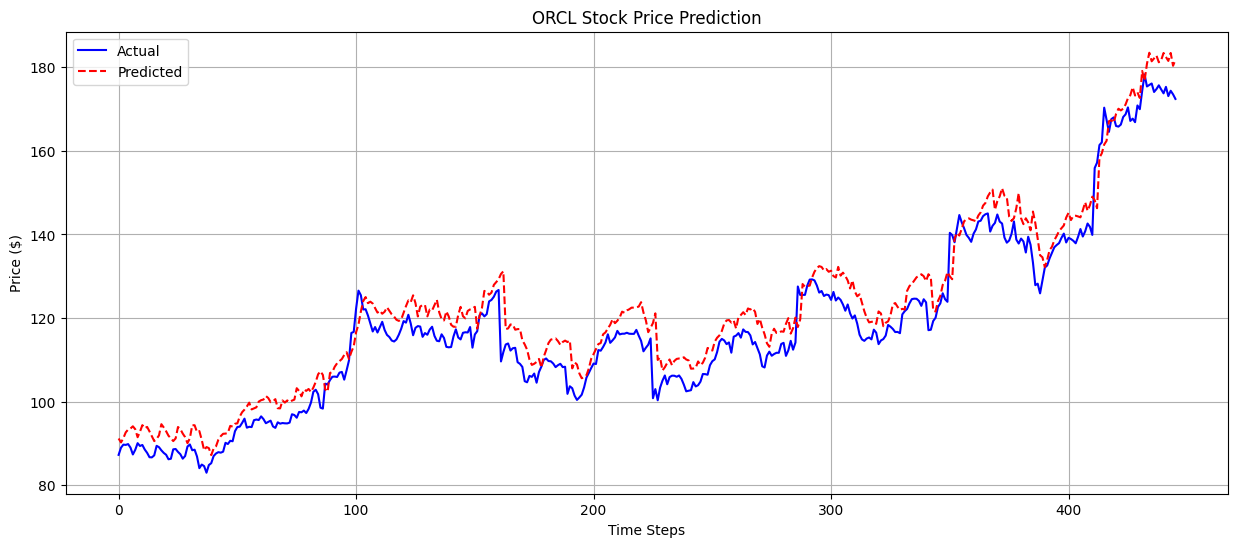


Analyzing META...

Evaluation Metrics for META:
MSE: 189.1582
RMSE: 13.7535
MAE: 9.6039


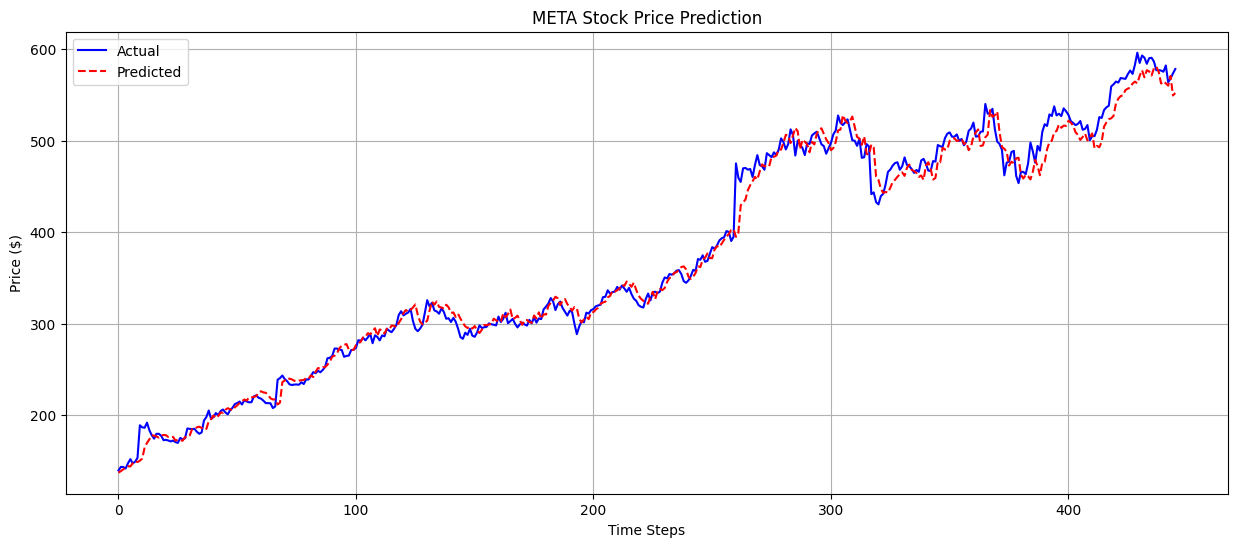


Summary of Metrics for All Stocks:
              MSE       RMSE        MAE
AAPL    38.109802   6.173314   5.165543
AMZN    37.519725   6.125335   5.048319
GME     10.665527   3.265812   2.412890
GOOGL   36.667131   6.055339   5.042664
NFLX   666.269156  25.812190  19.319015
TSLA   155.854328  12.484163   9.364497
MSFT    57.448230   7.579461   5.902433
NVDA    16.620046   4.076769   2.848504
AMD     51.762380   7.194608   5.616286
CRM     57.859188   7.606523   5.660751
JPM     40.090760   6.331726   5.489279
V       40.949264   6.399161   5.319372
MA      87.442261   9.351057   7.430960
MSTR   116.847261  10.809591   6.526621
DIS     26.998729   5.196030   4.684776
BA      55.524901   7.451503   5.884333
XOM     27.744726   5.267326   4.716227
ORCL    32.023200   5.658904   4.873256
META   189.158158  13.753478   9.603915
time: 4.04 s (started: 2024-11-18 10:38:53 +00:00)


In [21]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
        
    Returns:
        tuple: Lists of validation X and y for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)

In [22]:
def plot_future_predictions(historical_data, future_preds, actual_prices, ticker, scaler):
    """
    Plot historical data, future predictions, and actual prices in different colors
    
    Parameters:
    - historical_data: Historical price data
    - future_preds: Model's price predictions
    - actual_prices: Actual prices for the prediction period
    - ticker: Stock ticker symbol
    - scaler: The scaler used to transform the data
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    historical_prices = inverse_transform_price(historical_data, scaler)
    future_prices = inverse_transform_price(future_preds.flatten(), scaler)
    actual_future_prices = inverse_transform_price(actual_prices.flatten(), scaler)
    
    # Plot historical data
    plt.plot(range(len(historical_prices)), historical_prices, label='Historical', color='blue')
    
    # Plot predictions
    connection_indices = range(len(historical_prices)-1, len(historical_prices) + len(future_prices))
    connection_points = np.concatenate([historical_prices[-1:], future_prices])
    plt.plot(connection_indices, connection_points, label='Predicted', color='red', linestyle='--')
    
    # Plot actual future prices (starting from the last historical point)
    actual_indices = range(len(historical_prices)-1, len(historical_prices) + len(actual_future_prices))
    actual_points = np.concatenate([historical_prices[-1:], actual_future_prices])
    plt.plot(actual_indices, actual_points, label='Actual', color='green', linewidth=2)
    
    plt.title(f'{ticker} Stock Price - Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_future(model, last_sequence, n_steps_out, n_features):
    """
    Make future predictions using the last known sequence
    
    Args:
        model: trained LSTM model
        last_sequence: last known sequence of data (shape: [n_steps_in, n_features])
        n_steps_out: number of future steps to predict
        n_features: number of features in the input data
    """
    future_predictions = []
    current_sequence = last_sequence.reshape(1, n_steps_in, n_features)
    
    for _ in range(n_steps_out):
        # Get prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence by removing the first timestep and adding the prediction
        # We'll repeat the last prediction across all features as an approximation
        new_row = np.repeat(next_pred[0][0], n_features).reshape(1, 1, n_features)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_row], axis=1)
    
    return np.array(future_predictions)

# Future predictions
print("\nMaking Future Predictions...")
n_features = train_X.shape[2]

for i, ticker in enumerate(tickers):
    print(f"\nPredicting future prices for {ticker}...")
    
    # Get the last sequence from the validation data
    last_sequence = val_X[i][-1]
    
    # Make future predictions
    future_preds = predict_future(model, last_sequence, n_steps_out, n_features)
    
    # Get recent historical data for plotting (last 30 days)
    historical_data = val_y[i][-30:, 0]
    
    # Get actual future prices for comparison (next n_steps_out days)
    actual_future_prices = val_y[i][-n_steps_out:]
    
    # Print actual price predictions
    future_prices = inverse_transform_price(future_preds.flatten(), global_scaler)
    print(f"\n{ticker} - Next {n_steps_out} days price predictions:")
    for day, price in enumerate(future_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Print actual prices for comparison
    actual_prices = inverse_transform_price(actual_future_prices.flatten(), global_scaler)
    print(f"\n{ticker} - Actual prices for comparison:")
    for day, price in enumerate(actual_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Plot future predictions with historical context and actual prices
    try:
        plot_future_predictions(historical_data,future_preds,actual_future_prices,ticker,global_scaler)
    except Exception as e:
        print(f"Error plotting predictions for {ticker}: {e}")
        continue



Making Future Predictions...

Predicting future prices for AAPL...


ValueError: cannot reshape array of size 20 into shape (1,14,20)

time: 36.5 ms (started: 2024-11-18 10:39:59 +00:00)
